# GPN Cup 2021
## Кирилл Захаров

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from gensim.models import Word2Vec

from tqdm.notebook import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

#### Импорт транзакций

In [118]:
transactions = pd.read_parquet('transactions.parquet')

In [119]:
transactions.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002335,0.000000,3338297,0.147929,78634.0,102,2171-07-23
1,1158,0.002317,0.000000,3386107,0.134562,20900.0,101,2171-07-23
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23
4,1158,0.002355,0.000000,3257281,0.115023,67691.0,58,2171-07-23


In [120]:
len(transactions['client_id'].unique()) #Количество уникальных покупателей

370083

In [121]:
len(transactions['sku_id'].unique()) #Количество уникальных продуктов, которые покупали

4873

In [122]:
transactions.shape

(7620119, 8)

In [123]:
products_with_a = transactions.loc[np.where((transactions['number']!= 0.0) & (transactions['litrs']!= 0.0))]['sku_id']

In [131]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620119 entries, 0 to 7620118
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   sku_id     int64         
 1   price      float64       
 2   number     float64       
 3   cheque_id  int64         
 4   litrs      float64       
 5   client_id  float64       
 6   shop_id    int64         
 7   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 465.1 MB


#### Посмотрим есть ли данные типа None

In [126]:
transactions.isna().any()

sku_id       False
price        False
number       False
cheque_id    False
litrs        False
client_id     True
shop_id      False
date         False
dtype: bool

In [127]:
indx = np.where(transactions['client_id'].isna())[0]

Поскольку пустые данные содержатся в столбце клиентов, а их тип данных float64, то заменим None на нули.

In [128]:
transactions['client_id'] = transactions['client_id'].replace(np.nan, 0) 

In [129]:
transactions.isna().any()

sku_id       False
price        False
number       False
cheque_id    False
litrs        False
client_id    False
shop_id      False
date         False
dtype: bool

#### Импорт таблицы с номенклатурой

In [52]:
nomenclature = pd.read_parquet('nomenclature.parquet')

In [53]:
nomenclature.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


#### Посмотрим на неизвестные данные

In [54]:
nomenclature['full_name'].value_counts() #для неизвестных данных используется unknown

unknown                                                                              1370
Шоколад Ritter SPORT молочный обжаренный орех лещина 100г                               1
Сахар ЧАЙКОФСКИЙ рафинад 500г                                                           1
Стики HEETS gold selection                                                              1
Батончик VP Laboratory Protein Low Carb шоколад 35г                                     1
                                                                                     ... 
Очки Cafa France CF221759Y водителя желтая линза                                        1
Хлебцы АГУША мини рисовые ягодное ассорти 30г                                           1
Гриль-дог Fly Cafe сосиска 3 перца,сыр тш 164г                                          1
Напиток 28Seeds суперфуд безалкогольный неУранированный имбирь,лайм дой-пак 0,25л       1
Конфеты Rondo освежающие мята 30г                                                       1
Name: full

В дальнейшим неизвестные товары нам не понадобятся, поэтому удалим их, для этого сначал поменяем их на None.

In [55]:
nomenclature['full_name'] = nomenclature['full_name'].replace('unknown', None)

In [56]:
nomenclature.isna().sum()

sku_id          0
full_name    1379
brand           9
sku_group       0
OTM             9
units           9
country         9
dtype: int64

In [57]:
nomenclature = nomenclature.dropna()
nomenclature.isna().sum()

sku_id       0
full_name    0
brand        0
sku_group    0
OTM          0
units        0
country      0
dtype: int64

In [58]:
nomenclature.shape

(3724, 7)

In [108]:
nomenclature[nomenclature['sku_id'].isin(products_with_a.drop_duplicates()[:30])].head()

,sku_id,full_name,brand,sku_group,OTM,units,country
59,264,Сигареты NEXT super slims violet,NEXT,Табачные изделия,Нет,шт,РОССИЯ
70,4503,Сигареты Winston super slims fresh menthol/XS ...,Winston,Табачные изделия,Нет,unknown,РОССИЯ
229,2346,Сигареты Chesterfield classic red,Chesterfield,Табачные изделия,Нет,шт,unknown
389,199,Напиток Red Bull energy drink энергетический ж...,Red Bull,Энергетические напитки,Нет,л,АВСТРИЯ
718,2904,Батончик Fazer Kismet шоколадно-вафельный нуга...,Fazer,Кондитерские изделия,Нет,г,ФИНЛЯНДИЯ


#### Объединим таблицы в одну. Для каждого значения таблицы transactions добавим описание товара из таблицы nomenclature, для это замержим по ключам слева.

In [159]:
data = pd.merge(transactions, nomenclature, how='left', on=['sku_id'])
data.dropna(inplace=True)

In [160]:
data.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт,unknown
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23,Сигареты Parker&Simpson duo purple,Parker&Simpson,Табачные изделия,Нет,шт,РОССИЯ
11,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ
12,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ
13,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ


In [161]:
data = data.drop('date', axis=1) #удаление даты

#### Группы товаров для рекомендаций

In [62]:
groups = ['вода', 'Сладкие Уранированные напитки, холодный чай', 'Кофейные напитки с молоком', \
          'Энергетические напитки', 'Снеки', 'Соки и сокосодержащие напитки']

In [63]:
data[data['sku_group'].isin(groups)].head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group,OTM,units,country
38,199,0.011237,0.000452,2429861,0.104183,2937.0,78,Напиток Red Bull energy drink энергетический ж...,Red Bull,Энергетические напитки,Нет,л,АВСТРИЯ
46,3328,0.007132,0.000452,2108067,0.104183,128895.0,21,"Кофе Fly Cafe Моккачино 0,4л",Fly Cafe,Кофейные напитки с молоком,Нет,л,РОССИЯ
354,407,0.005080,0.000452,3338387,0.104183,237410.0,102,Напиток Interkvass Kombucha классический стекл...,unknown,"Сладкие Уранированные напитки, холодный чай",Нет,л,РОССИЯ
444,2194,0.006619,0.000452,2345328,0.104183,225982.0,40,"Напиток Mountain DEW Уранированный ПЭТ 0,5л",Mountain DEW,"Сладкие Уранированные напитки, холодный чай",Нет,л,unknown
458,3418,0.007132,0.000452,1644886,0.104183,14041.0,41,Напиток Fly Cafe молокосодержащий кофейный Лат...,Fly Cafe,Кофейные напитки с молоком,Да,л,unknown


# Рекомендательная система

In [302]:
data['sku_id'] = data['sku_id'].astype(str) #поменяем тип данных товара на строчные для дальнейшей работы

In [303]:
customers = data['client_id'].unique().tolist() #создаем список с уникальными клиентами
len(customers)

351392

In [304]:
# # shuffle customer ID's
# # np.random.shuffle(customers)

# # extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.4*len(customers)))]

# # split data into train and validation set
# train_df = data[data['client_id'].isin(customers_train)]
# validation_df = data[~data['client_id'].isin(customers_train)]

#### Формируем обучающую выборку

In [305]:
X_train, X_test = train_test_split(data, test_size=0.1, shuffle=True, random_state=5)

In [306]:
X_train.head(2)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group,OTM,units,country
1616917,3336,0.010210,0.000452,1488308,0.104183,369222.0,7,Напиток Fly Cafe молокосодержащий кофейный Мок...,Fly Cafe,Кофейные напитки с молоком,Нет,л,РОССИЯ
4358752,2637,0.008979,0.000452,650541,0.104183,268010.0,89,Сигареты PARLIAMENT platinum blue,PARLIAMENT,Табачные изделия,Нет,шт,unknown


#### Создадим массив истории покупок определенного товара для каждого клиента

In [334]:
purchases_train = list(X_train.groupby('client_id')['sku_id'].apply(list).to_dict().values())

In [365]:
purchases_train_keys = list(X_train.groupby('client_id')['sku_id'].apply(list).to_dict().keys())

In [351]:
purchases_train[1:4]

[['810', '218'],
 ['997', '2467', '2468', '3361'],
 ['3085', '254', '3324', '254']]

In [332]:
# # list to capture purchase history of the customers
# purchases_val = []

# # populate the list with the product codes
# for i in tqdm_notebook(validation_df['client_id'].unique()):
#     temp = validation_df[validation_df['client_id'] == i]['sku_id'].tolist()
#     purchases_val.append(temp)

  0%|          | 0/210835 [00:00<?, ?it/s]

#### Построим модель Word2Vec для товаров

In [336]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(16638969, 48351970)

In [337]:
# сохраним модель
model.save("word2vec_2.model")

In [338]:
# extract all vectors
X = model.wv[model.wv.index_to_key]

X.shape

(3106, 100)

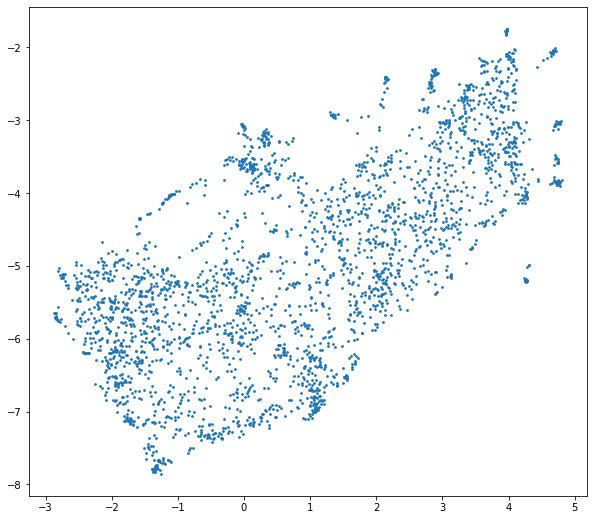

In [293]:
import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.subplots(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

plt.show()

#### Создание словаря товаров и их характеристик

In [376]:
# создадим датафрейм с интересующими нас признаками
products = X_train[['sku_id', 'sku_group', 'price', 'brand', 'full_name']]
products = products.copy()

# удаляем повторяющиеся товары
products.drop_duplicates(inplace=True, subset='sku_id', keep="last")

# создаем словарь продуктов с названиями товаров, брендом, ценой и группой товара
groups_dict = products.groupby('sku_id')['sku_group'].apply(list).to_dict()
price_dict = products.groupby('sku_id')['price'].apply(list).to_dict()
name_dict = products.groupby('sku_id')['full_name'].apply(list).to_dict()
brand_dict = products.groupby('sku_id')['brand'].apply(list).to_dict()
sku_dict = products.groupby('sku_id')['sku_id'].apply(list).to_dict()

In [377]:
# Объединение в один словарь
keys = groups_dict.keys()
values = zip(sku_dict.values(), groups_dict.values(), price_dict.values(),\
             name_dict.values(), brand_dict.values())

In [378]:
products_dict = dict(zip(keys, values))

In [379]:
model.wv.similar_by_vector('1913', topn = len(products))[1:];

#### Функция для поиска похожих товаров
На вход подается вектор из словаря модели и число требуемых рекомендаций. Сначала отбираем все вектора, но уже упорядоченные по схожести, затем отбираем 20 лучших, которые принадлежат необходимым группам товаров.

In [470]:
def similar_products(v, n = 20):
    similar_products = model.wv.similar_by_vector(v, topn = len(products))[1:]
    
    recommend = [] #здесь будут храниться рекомендации
    k = 0 # счетчик для отбора только 20 лучших
    
    for i, product in enumerate(similar_products):
        if products_dict[product[0]][1][0] in groups and k != 20:
            recommend.append((products_dict[product[0]][0][0], products_dict[product[0]][3][0],\
                    products_dict[product[0]][1][0], products_dict[product[0]][4][0], \
                    products_dict[product[0]][2][0], product[1], k+1))
            k += 1
    return recommend

In [471]:
recommendations = similar_products(model.wv['1913'])

In [472]:
pd.DataFrame(recommendations, columns = ['sku_id', 'full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,3010,Чипсы Ecostoria нори хрустящие оригинальные 30г,Снеки,unknown,0.005387,0.453469,1
1,279,"Цукаты Дары Природы ананас,папайя 150г",Снеки,Дары Природы,0.005387,0.423004,2
2,978,Арахис Nic Nac's хрустящая оболочка приправа 125г,Снеки,Nic Nac's,0.003848,0.396883,3
3,568,Батончик Quest Nutrition Questbar протеин брау...,Снеки,Quest Nutrition,0.002822,0.374196,4
4,2324,Напиток FuzeTea безалкогольный неУранированный...,"Сладкие Уранированные напитки, холодный чай",FuzeTea,0.003540,0.372830,5
5,1393,Чипсы Slang кокосовые сахарный тросник 30г,Снеки,unknown,0.004053,0.366932,6
6,189,Напиток Notpil Ice tea безалкогольный неУранир...,"Сладкие Уранированные напитки, холодный чай",Notpil Ice tea,0.007132,0.356720,7
7,2377,Банан Можно Много сублимированный 20г,Снеки,unknown,0.003027,0.356306,8
8,1012,Напиток из Черноголовки Уранированный байкал с...,"Сладкие Уранированные напитки, холодный чай",из Черноголовки,0.007132,0.350945,9
9,1567,Напиток Red Bull Red Edition энергетический ар...,Энергетические напитки,Red Bull,0.010210,0.349431,10


In [321]:
len(recommendations)

20

#### Использование истории покупок клиента

In [473]:
def history_aggregation(client_products):
    model_product = []
    
    for product in client_products:
        try:
            model_product.append(model.wv[product])
            
        except KeyError:
            continue
        
    return np.mean(model_product, axis=0)

In [474]:
purchases_train[1]

['810', '218']

In [475]:
X_train[X_train['client_id'] == 223748.0]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group,OTM,units,country
1418547,3342,0.008671,0.000452,1936772,0.104183,223748.0,3,"Кофе Fly Cafe Капучино 0,4л",Fly Cafe,Кофейные напитки с молоком,Нет,л,unknown
2104701,3324,0.006619,0.000452,1876911,0.104183,223748.0,26,Напиток Fly Cafe молокосодержащий кофейный Флэ...,Fly Cafe,Кофейные напитки с молоком,Да,л,unknown


In [476]:
recommendationsH = similar_products(history_aggregation(purchases_train[0])); #by client history

In [479]:
pd.DataFrame(recommendationsH, columns = ['sku_id','full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,3271,Квас НИКОЛА традиционный ПЭТ 1л,"Сладкие Уранированные напитки, холодный чай",Никола,0.010005,0.688794,1
1,3039,Напиток G-Fly (СТМ) Football Edition энергетич...,Энергетические напитки,G-Fly (СТМ),0.006414,0.640608,2
2,3863,"Нектар Теди морковь ст 0,33л",Соки и сокосодержащие напитки,Теди,0.005080,0.638890,3
3,790,"Батончик Здоровый перекус мюсли орехи,мед 55г",Снеки,unknown,0.002771,0.633804,4
4,808,Напиток G-Fly (СТМ) original энергетический бе...,Энергетические напитки,G-Fly (СТМ),0.005080,0.622895,5
5,434,Напиток Red Bull energy drink энергетический ж...,Энергетические напитки,Red Bull,0.008671,0.620483,6
6,4823,"Напиток Adrenaline rush энергетический ж/б 0,25л",Энергетические напитки,Adrenaline rush,0.005080,0.610488,7
7,408,Напиток Local-Cola сильноУранированный мультип...,"Сладкие Уранированные напитки, холодный чай",Local-Cola,0.006927,0.609389,8
8,1533,Напиток Red Bull sugarfree энергетический ж/б ...,Энергетические напитки,Red Bull,0.005080,0.600096,9
9,99,Напиток Schweppes Уранированный spritz аперити...,"Сладкие Уранированные напитки, холодный чай",Schweppes,0.005900,0.596939,10


# Transactions for Submission

In [353]:
trans_subm = pd.read_parquet('transactions-for_submission.parquet')

In [354]:
trans_subm.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002304,0.000000,734259,0.142106,223748.0,42,2171-08-01 09:00:00
1,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
2,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
3,1158,0.002304,0.000000,734264,0.138006,NaN,42,2171-08-01 09:00:00
4,1534,0.002822,0.000452,734266,0.104183,NaN,42,2171-08-01 09:00:00


In [402]:
answer = pd.DataFrame(similar_products(model.wv['555']), columns = ['sku_id', 'full_name',\
                                                                    'sku_group', 'brand', 'price', 'similarity'])

In [486]:
submissions = trans_subm['sku_id'].values[:10]
recs = []
for i in submissions:
    try:
        t = similar_products(model.wv[i])
        for j in t:
            recs.append([j[0], j[-1]])
    except KeyError:
        continue

In [487]:
result = pd.DataFrame(recs, columns = ['sku_id', 'position'])

In [491]:
result.head(40)

,sku_id,position
0,3331,1
1,4782,2
2,4793,3
3,4789,4
4,3419,5
5,3344,6
6,3335,7
7,1634,8
8,3340,9
9,3333,10


In [355]:
example = pd.read_parquet('submission-example.parquet')

In [356]:
example

,cheque_id,sku_id,position
0,734259,1499,1
1,734259,1053,2
2,734259,1278,3
3,734259,3719,4
4,734259,3292,5
5,734259,1951,6
6,734259,3186,7
7,734259,3333,8
8,734259,2921,9
9,734259,2194,10
